In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import html
import re
import json
import csv
import tweepy
import re
import os
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BartTokenizer, BartModel
from transformers import pipeline
from dotenv import load_dotenv
from tqdm import tqdm
load_dotenv()

consumer_key = os.environ.get('API_KEY')
consumer_secret = os.environ.get('API_KEY_SECRET')
access_token = os.environ.get('ACCES_TOKEN')
access_token_secret = os.environ.get('ACCESS_TOKEN_SECRET')


#before any of this, you need a Twitter Developer API. The Standard API works fine for this
#IMPORTANT: the academic API does not work with tweepy (yet?). Get the standard API and explain to Twitter, they probably won't have a problem with it

#define our function: what are we doing, what arguments do we need to do it?
def search_for_hashtags(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase):
    
    #create an authorization for accessing Twitter (aka tell the program we have permission to do what we're doing)
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    #initialize Tweepy API
    api = tweepy.API(auth)
    
    #make the name of the spreadsheet we will write to
    #it will be named whatever we search
    fname = '_'.join(re.findall(r"#(\w+)", hashtag_phrase))

    #open the spreadsheet we will write to
    with open('%s.csv' % (fname), 'w', encoding='utf-8') as file:

        w = csv.writer(file)

        #write header row to spreadsheet
        w.writerow(['timestamp', 'location', 'tweet_text', 'username', 'all_hashtags', 'followers_count'])

        #for each tweet matching our hashtags, write relevant info to the spreadsheet
        #max we can pull is 500,000 tweets a month; I have it set to 100
        for tweet in tweepy.Cursor(api.search_tweets, q=hashtag_phrase+' -filter:retweets', \
                                   lang="en", tweet_mode='extended').items(500):
            w.writerow([tweet.created_at,tweet.user.location, tweet.full_text.replace('\n',' ').encode('utf-8'), tweet.user.screen_name.encode('utf-8'), [e['text'] for e in tweet._json['entities']['hashtags']], tweet.user.followers_count])

    
hashtag_phrase = input('Hashtag Phrase ') #you'll enter your search terms in the form "#xyz" ; use logical operators AND/OR

if __name__ == '__main__':
    search_for_hashtags(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase)


print('INITIALIZING DATA PROCESSING + CLEANING')

try:
    user_csv = input('Please input the exact name of the CSV file you wish to analyze: ')
    tweet_column = input('Please input the name of the column containing the tweets: ')
    tweet_column_with_quotes = "'" + tweet_column + "'"

    dataframe = pd.read_csv(user_csv, delimiter=',',encoding='utf-8', header = 0)
    pd.set_option('display.max_colwidth', None)
    dataframe.rename(columns={tweet_column:'tweet'}) #renaming the tweet column to 'tweet'
    

except FileNotFoundError:
    print('There was an error finding the CSV you requested, please check the following:','\n', '1. The CSV file is in the correct directory', '\n', '2. You gave the correct name of the file, following the syntax: yourfilename.csv')


df_copy = dataframe.copy() #creating a copy of the dataframe
df_copy['tweet'] = df_copy['tweet'].str.lower() #making everything lower case
df_copy.drop_duplicates(subset='tweet', keep='first', inplace=True, ignore_index=False) #removing duplicates
df_copy[~df_copy.tweet.str.startswith('rt')] #removing retweets
df_copy['tweet'] = df_copy['tweet'].apply(lambda k: html.unescape(str(k))) #removing unnecessary characters

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed mentions
    text = re.sub(r'#', '', text) #Removed hashtags
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlink
    text = re.sub(r'\'[\s]+', '', text) #Remove apostrophe
    text = re.sub(r'\...+', '', text) #Remove dots
    text = re.sub(r'\!', '', text) #Remove exclamation  marks

    return text

df_copy['tweet'] = df_copy['tweet'].apply(clean_text)

df_copy.to_csv('Cleaned_Data.csv')

print('\n','DATA PROCESSING + CLEANING COMPLETE', '\n')
print('INITIALIZING DATA ANALYSIS')

print('The standard model being used is Valhalla, an optimized version of the Bart Large pretrained analysis model providing faster results.', '\n', 'If you have not used it before, it may take a while to download as it is quite large.','\n')

model = input('If you wish to use Bart Large instead, type y.')

if model == 'y':
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
    model = BartModel.from_pretrained('facebook/bart-large')
else:
    tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-1")
    model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-1", device = -1)

try:
    classifier = pipeline("zero-shot-classification", model = model, tokenizer = tokenizer, device = -1) #classifier = pipeline(task='zero-shot-classification', model=model, tokenizer=tokenizer, framework='pt')
except RuntimeError:
    print("A runtime error occurred, check if tensorflow and pytorch are correctly installed, need to be version >= 2")

df_original  = pd.read_csv(r'Cleaned_Data.csv')
rows = df_original['tweet'].count()

try:
    number_of_rows = int(input(f'Please specify the number of rows you wish to analyze, in your current dataset, there are {rows} rows of tweets, if you wish to look at them all, input any non-numerical character'))
    df_name = df_original.head(number_of_rows)
except ValueError:
    df_name = df_original

candidate_labels = []
candidate_results = []

def approval():
    candidate_labels = []
    labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')

    while labels != 'done':
        candidate_labels.append(labels)
        labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')
    
    print(f'{candidate_labels}')
    print('\n')
    approved = input('Are these labels correct? if so, type "y", if not, type any other character')

    if approved != "y":
        approval()
    else:
        print('APPRPOVED, INITALIZING TWEET ANALYSIS', '\n')
    return candidate_labels

candidate_labels = approval()
print(candidate_labels)

for x in range(len(candidate_labels)):
    candidate_results.append(0)

for sent in tqdm(df_name['tweet'].values):
        
    res = classifier(sent, candidate_labels, multi_label = True) #change multilabel to True for different results

    for i in range(len(candidate_labels)):
      if res['labels'][0] == candidate_labels[i] and res['scores'][0] > 0.5:
          candidate_results[i] = candidate_results[i] + 1

    if res['scores'][0] > 0.5: #the code below this can be removed if you do not wish to have all of the results printed (might be useful for when the program is actually implemented)
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print('\n')

data = {'labels': candidate_labels, 'values': candidate_results}
df_frequency = pd.DataFrame(data, columns=['labels', 'values'])
df_frequency.head()
sns.barplot(data = df_frequency, x = 'labels', y = 'values')

TypeError: Consumer key must be string or bytes, not NoneType

INITIALIZING DATA PROCESSING + CLEANING
                     Timestamp          location  \
0    2021-12-18 10:50:01+00:00               NaN   
1    2021-12-18 10:50:00+00:00          Kent, UK   
2    2021-12-18 10:48:18+00:00   Česká republika   
3    2021-12-18 10:48:12+00:00               NaN   
4    2021-12-18 10:48:00+00:00     London, Paris   
..                         ...               ...   
495  2021-12-18 08:12:48+00:00     United States   
496  2021-12-18 08:12:17+00:00   Los Angeles, CA   
497  2021-12-18 08:11:36+00:00      Here and Now   
498  2021-12-18 08:11:16+00:00   Bangalore India   
499  2021-12-18 08:11:00+00:00  Faaborg, Denmark   

                                                                                                                                                                                                                                                                                                                                               

  5%|▌         | 1/20 [00:01<00:32,  1.69s/it]

b'$799 standup comedy career launching 5 star workbook- gift your funny friend or family member this unique gift purchase link:  c  washingtondc az phoenix nj texas nurses doctors walterreed va vahospital surgery covid'
['covid', 'positive', 'negative']
[0.9273540377616882, 0.41873201727867126, 0.0016402716282755136]




 10%|█         | 2/20 [00:02<00:21,  1.20s/it]

b'news: the efl say 25% of players are not vaccinated against covid kmfmnews 
['negative', 'covid', 'positive']
[0.7195845246315002, 0.6063669919967651, 0.0031882126349955797]




 15%|█▌        | 3/20 [00:03<00:16,  1.01it/s]

b'covid: action needed to limit hospital admissions - sage scientists 
['covid', 'negative', 'positive']
[0.6725738048553467, 0.5269215106964111, 0.23183830082416534]




 20%|██        | 4/20 [00:04<00:15,  1.04it/s]

b"meanwhile in ireland covid virus is very dangerous after 8pm before that it's less dangerous  
['covid', 'negative', 'positive']
[0.9008359909057617, 0.7013845443725586, 0.014535023830831051]




 25%|██▌       | 5/20 [00:07<00:26,  1.78s/it]

b'triple vaccinated \xf0\x9f\xa6\xb8\xf0\x9f\x8f\xbb\xe2\x80\x8d\xe2\x99\x80\xef\xb8\x8f\xf0\x9f\x92\xaa  feeling the power growing in my veins \xf0\x9f\xa4\xaa\xf0\x9f\x99\x88  getvaccinated vaccinated covid'
['covid', 'positive', 'negative']
[0.964379608631134, 0.8170974850654602, 0.15723785758018494]




 30%|███       | 6/20 [00:08<00:22,  1.61s/it]

b"la's also playing the omicrondeltablues: los angeles county is seeing the highest number of daily covid-19 cases in four months (abc7) 
['negative', 'covid', 'positive']
[0.6952006220817566, 0.6618661284446716, 0.0013968219282105565]




 35%|███▌      | 7/20 [00:11<00:24,  1.88s/it]

b'omicron covid i\xe2\x80\x99ve just been told by testandtrace that if it is the omicron variant that they will contact you twice at present my notes do not have omicron on them also it\xe2\x80\x99s a 14 day infection, so i could have picked it up at work or when i went to hospital'
['covid', 'negative', 'positive']
[0.9805971384048462, 0.24216341972351074, 0.012036867439746857]




 40%|████      | 8/20 [00:12<00:20,  1.74s/it]

b'it is so unfortunate that this is going to happen as we head into the third winter of covid however we must think about what these rapidly rising cases not just do to patients but to our healthcare systems and staff 
['negative', 'covid', 'positive']
[0.9568979740142822, 0.9096902012825012, 0.00018119026208296418]




 45%|████▌     | 9/20 [00:14<00:19,  1.74s/it]

b'paddy power in his d4 jumper \xe2\x80\x9ci\xe2\x80\x99ve had more vaccines than nights out\xe2\x80\x9d\xc2\xa0covid-19 
['covid', 'negative', 'positive']
[0.9234002828598022, 0.20050708949565887, 0.13461603224277496]




 50%|█████     | 10/20 [00:15<00:15,  1.60s/it]

b'a bit like all the fear and hysteria being whipped up about covid and vacinnepassports \xf0\x9f\x98\x8f 
['negative', 'covid', 'positive']
[0.5454208850860596, 0.05468060448765755, 0.0002922392450273037]




 55%|█████▌    | 11/20 [00:16<00:12,  1.34s/it]

b'no sh covid is seasonal, who could have know??? srcsm 
['covid', 'negative', 'positive']
[0.6959219574928284, 0.16626030206680298, 0.0015627957182005048]




 60%|██████    | 12/20 [00:17<00:10,  1.31s/it]

b'give us your best covid christmas carols:  omicron all ye faithful oh lateral flow of bethlehem  anothercovidchristmas'
['covid', 'positive', 'negative']
[0.7891451716423035, 0.13971634209156036, 0.0010127630084753036]




 65%|██████▌   | 13/20 [00:18<00:08,  1.17s/it]

b'save lives do not drink and drive   safefestive covid-19 
['covid', 'positive', 'negative']
[0.6387516260147095, 0.2408214509487152, 0.023562628775835037]




 70%|███████   | 14/20 [00:19<00:07,  1.23s/it]

b'the national football league (nfl) postponed three games this weekend because of covid-19 outbreaks  nationalfootballleague coronavirus covid_19 covid19   read:  
['negative', 'covid', 'positive']
[0.6930001974105835, 0.44998008012771606, 0.0017961276462301612]




 75%|███████▌  | 15/20 [00:21<00:07,  1.46s/it]

b'at some point, these folks should end up in jail starting with fauci and daszak   yet we are still arguing with each other while these criminals are still being asked what we should do the two that are responsible (as more evidence shows us) are making the rules   covid 
['negative', 'covid', 'positive']
[0.8448957800865173, 0.7758967876434326, 0.0024324171245098114]




 80%|████████  | 16/20 [00:24<00:07,  1.85s/it]

b'remember: if you\xe2\x80\x99re wearing a facecovering, covid can\xe2\x80\x99t enter your body via your chin \xf0\x9f\xa4\xa6\xf0\x9f\x8f\xbb\xe2\x80\x8d\xe2\x99\x82\xef\xb8\x8f 
['covid', 'negative', 'positive']
[0.8810495734214783, 0.3096586763858795, 0.027602503076195717]




 85%|████████▌ | 17/20 [00:25<00:05,  1.72s/it]

b'now is the time to get your booster vaccine and get into a routine of daily vitamin intake - covid omicron flu publichealth healthcare nhs\xf0\x9f\x92\x99 
['covid', 'positive', 'negative']
[0.5975480675697327, 0.03787647932767868, 0.007845061831176281]




 90%|█████████ | 18/20 [00:26<00:02,  1.46s/it]

b'"huge numbers of people getting sick all at once will alter everyday reality"omicron covid  
['covid', 'negative', 'positive']
[0.9423156976699829, 0.4753589332103729, 0.010571897961199284]




 95%|█████████▌| 19/20 [00:27<00:01,  1.29s/it]

b'3 dead in karachi blast  covid internationalnews newsfeed breakingnews breaking wewantjustice'
['covid', 'negative', 'positive']
[0.9800358414649963, 0.20018421113491058, 0.001947790035046637]




100%|██████████| 20/20 [00:29<00:00,  1.46s/it]

b'morrison is like the tinman without a heart in the wizard of oz except the tinman wished that he had a heart morrison just doesn\xe2\x80\x99t care covid asylumseekers women'
['negative', 'covid', 'positive']
[0.7731471657752991, 0.39154738187789917, 0.0011527641909196973]




<AxesSubplot:xlabel='labels', ylabel='values'>

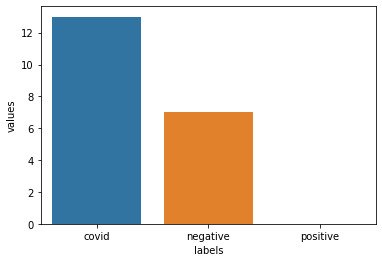

In [1]:
#THIS VERSION IS NOT FUNCITONING CORRECTLY

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import html
import re
from transformers import pipeline
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BartTokenizer, BartModel
from transformers import pipeline

print('INITIALIZING DATA PROCESSING + CLEANING')

try:
    user_csv = input('Please input the exact name of the CSV file you wish to analyze: ')
    tweet_column = input('Please input the name of the column containing the tweets: ')
    tweet_column_with_quotes = "'" + tweet_column + "'"

    dataframe = pd.read_csv(user_csv, delimiter=',',encoding='utf-8', header = 0)
    pd.set_option('display.max_colwidth', None)
    print(dataframe)
    dataframe.rename({tweet_column_with_quotes:'tweet'}, axis = 1, inplace = True) #why the fuck doesn't renaming this actually work?!?!? it's pissing me off
    print(dataframe)
    
except FileNotFoundError:
    print('There was an error finding the CSV you requested, please check the following:','\n', '1. The CSV file is in the correct directory', '\n', '2. You gave the correct name of the file, following the syntax: yourfilename.csv')


df_copy = dataframe.copy() #creating a copy of the dataframe
df_copy['tweet'] = df_copy['tweet'].str.lower() #making everything lower case
print(df_copy['tweet'])
df_copy.drop_duplicates(subset='tweet', keep='first', inplace=True, ignore_index=False) #removing duplicates
df_copy[~df_copy.tweet.str.startswith('rt')] #removing retweets
df_copy['tweet'] = df_copy['tweet'].apply(lambda k: html.unescape(str(k))) #removing unnecessary characters

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed mentions
    text = re.sub(r'#', '', text) #Removed hashtags
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlink
    text = re.sub(r'\'[\s]+', '', text) #Remove apostrophe
    text = re.sub(r'[\...+]', '', text) #Remove dots
    text = re.sub(r'\!', '', text) #Remove exclamation  marks

    return text

df_copy['tweet'] = df_copy['tweet'].apply(clean_text)

df_copy.to_csv('Cleaned_Data.csv')

print('\n','DATA PROCESSING + CLEANING COMPLETE', '\n')
print('INITIALIZING DATA ANALYSIS')

print('The standard model being used is Valhalla, an optimized version of the Bart Large pretrained analysis model providing faster results.', '\n', 'If you have not used it before, it may take a while to download as it is quite large.','\n')

model = input('If you wish to use Bart Large instead, type y.')

if model == 'y':
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
    model = BartModel.from_pretrained('facebook/bart-large')
else:
    tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-1")
    model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-1", device = -1)

try:
    classifier = pipeline("zero-shot-classification", model = model, tokenizer = tokenizer, device = -1) #classifier = pipeline(task='zero-shot-classification', model=model, tokenizer=tokenizer, framework='pt')
except RuntimeError:
    print("A runtime error occurred, check if tensorflow and pytorch are correctly installed, need to be version >= 2")

df_original  = pd.read_csv(r'Cleaned_Data.csv')
rows = df_original['tweet'].count()

try:
    number_of_rows = int(input(f'Please specify the number of rows you wish to analyze, in your current dataset, there are {rows} rows of tweets, if you wish to look at them all, input any non-numerical character'))
    df_name = df_original.head(number_of_rows)
except ValueError:
    df_name = df_original

candidate_labels = []
candidate_results = []

def approval():
    candidate_labels = []
    labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')

    while labels != 'done':
        candidate_labels.append(labels)
        labels = input('Please specify the lables you wish to analyze the tweets with, type "done" once you have inputted the ones you wish to use')
    
    print(f'{candidate_labels}')
    print('\n')
    approved = input('Are these labels correct? if so, type "y", if not, type any other character')

    if approved != "y":
        approval()
    else:
        print('APPRPOVED, INITALIZING TWEET ANALYSIS', '\n')
    return candidate_labels

candidate_labels = approval()
print(candidate_labels)

for x in range(len(candidate_labels)):
    candidate_results.append(0)

for sent in tqdm(df_name['tweet'].values):
        
    res = classifier(sent, candidate_labels, multi_label = True) #change multilabel to True for different results

    for i in range(len(candidate_labels)):
      if res['labels'][0] == candidate_labels[i] and res['scores'][0] > 0.5:
          candidate_results[i] = candidate_results[i] + 1

    if res['scores'][0] > 0.5: #the code below this can be removed if you do not wish to have all of the results printed (might be useful for when the program is actually implemented)
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print('\n')

data = {'labels': candidate_labels, 'values': candidate_results}
df_frequency = pd.DataFrame(data, columns=['labels', 'values'])
df_frequency.head()
sns.barplot(data = df_frequency, x = 'labels', y = 'values')
